In [1]:
import numpy as np
import matplotlib.pyplot as plt

from docplex.mp.model import Model
from NPG_CMDP import CMDP_NPG
from ARNPG_CMDP import CMDP_ARNPG

"""Our code customizes the CMDP code from the paper:
Natural Policy Gradient Primal-Dual Method for Constrained Markov Decision Processes, Dongsheng Ding et al.
"""

"""Natural Policy Gradient Primal-Dual Method with Softmax Parametrization
"""

# Random Seed
np.random.seed(10)
# Problem Setup
gamma = 0.8
s, a = 20, 10

In [2]:
# Randomly generated probability transition matrix P((s,a) -> s') in [0,1]^{|S||A| x |S|}
raw_transition = np.random.uniform(0, 1, size=(s * a, s))
prob_transition = raw_transition / raw_transition.sum(axis=1, keepdims=1)
# Random positive rewards
reward = np.random.uniform(0, 1, size=(s * a))
# Random positive utilities
utility = np.random.uniform(0, 1, size=(s * a))
# Utility constraint offset b
b = 3
# Start state distribution
rho = np.ones(s) / s

In [3]:
def theta_to_policy(theta, s, a):
    """
    :param theta: |S||A| * 1
    :param s: |S|
    :param a: |A|
    :return: |S||A| * 1
    """
    prob = []
    for i in range(s):
        norm = np.sum(np.exp(theta[a * i:a * (i + 1)]))
        for j in range(a * i, a * (i + 1)):
            prob.append(np.exp(theta[j]) / norm)

    return np.asarray(prob)


def get_Pi(prob, s, a):
    """
    :param prob: |S||A| * 1
    :param s: |S|
    :param a: |A|
    :return: |S| * |S||A|
    """
    Pi = np.zeros((s, s * a))
    for i in range(s):
        Pi[i, i * a:(i + 1) * a] = prob[i * a:(i + 1) * a]

    return Pi


def grad_state_action(prob, state, action):
    """
    :param prob: |S||A| * 1
    :param state: 1 * 1
    :param action: 1 * 1
    :return: \nabla_{\theta} \pi_{\theta}(s,a)
    """
    grad = np.zeros(s * a)
    for j in range(0, a):
        if j == action:
            grad[a * state + j] = prob[a * state + j] * (1 - prob[a * state + j])
        else:
            grad[a * state + j] = -prob[a * state + action] * prob[a * state + j]

    return grad


def grad_state(qvals, prob, state):
    grad = np.sum([qvals[state * a + i] * grad_state_action(prob, state, i) for i in range(0, a)], axis=0)
    return grad


def grad(qvals, prob, d_pi):
    grad = np.sum([d_pi[i] * grad_state(qvals, prob, i) for i in range(0, s)], axis=0)
    return grad


def Fisher_info(prob, d_pi):
    """
    :param prob: |S||A * 1
    :param d_pi: |S| * 1
    :return: Fisher information matrix \nabla_{\theta} \pi_{\theta}(s,a) x {\nabla_{\theta} \pi_{\theta}(s,a)}^T
    """
    qvals_one = np.ones(s * a)
    grad = np.sum([d_pi[i] * grad_state(qvals_one, prob, i) for i in range(0, s)], axis=0)
    fisher = np.outer(grad, grad) + 1e-3 * np.identity(s * a)
    return fisher


def ell(qvals, prob, rho):
    """
    Calculate V from Q value function
    :param qvals: |S||A| * 1
    :param prob: |S||A| * 1
    :param rho: |S| * 1
    :return: V |S| * 1
    """
    V = np.zeros(s)
    for i in range(s):
        V[i] = np.sum([qvals[i * a + j] * prob[i * a + j] for j in range(a)])

    ell = np.dot(V, rho)
    return ell


def proj(scalar):
    offset = 100
    if scalar < 0:
        scalar = 0

    if scalar > offset:
        scalar = offset

    return scalar


# Run policy iteration to get the optimal policy and compute the constraint violation
# Feasibility checking: negative constraint violation leads to the Slater condition
def policy_iter(q_vals, s, a):
    new_policy = np.zeros(s * a)
    for i in range(s):
        idx = np.argmax(q_vals[i * a:(i + 1) * a])
        new_policy[i * a + idx] = 1

    return new_policy

raw_vec = np.random.uniform(0, 1, size=(s, a))
prob_vec = raw_vec / raw_vec.sum(axis=1, keepdims=1)
init_policy = prob_vec.flatten()
curr_policy = np.random.uniform(0, 1, size=(s * a))
new_policy = init_policy

while np.count_nonzero(curr_policy - new_policy) > 0:
    curr_policy = new_policy
    Pi = get_Pi(curr_policy, s, a)
    mat = np.identity(s * a) - gamma * np.matmul(prob_transition, Pi)
    q_vals = np.dot(np.linalg.inv(mat), utility)
    new_policy = policy_iter(q_vals, s, a)

ell_star = ell(q_vals, new_policy, rho)
print('Feasibility checking: constraint violation', b - ell_star)


# calculate the optimal reward via LP
model = Model('CMDP')
# create continuous variables
idx = [(i, j) for i in range(s) for j in range(a)]
x = model.continuous_var_dict(idx)

for i in range(s):
    for j in range(a):
        model.add_constraint(x[i, j] >= 0)

for s_next in range(s):
    model.add_constraint(
        gamma * model.sum(x[i, j] * prob_transition[i * a + j][s_next] for i in range(s) for j in range(a))
        + (1 - gamma) * rho[s_next] == model.sum(x[s_next, a_next] for a_next in range(a)))

model.add_constraint(model.sum(x[i, j] * utility[i * a + j] / (1 - gamma) for i in range(s) for j in range(a)) >= b)

model.maximize(model.sum(x[i, j] * reward[i * a + j] / (1 - gamma) for i in range(s) for j in range(a)))
solution = model.solve()

Feasibility checking: constraint violation -1.5250274256848044


In [4]:
# class CMDP_NPG:
#     def __init__(self, reward, utility, s, a, b, rho, gamma, prob_transition, model):
#         self.reward = reward
#         self.utility = utility
#         self.s = s
#         self.a = a
#         self.b = b
#         self.rho = rho
#         self.gamma = gamma
#         self.prob_transition = prob_transition
#         self.model = model
        
#         self.theta = np.random.uniform(0, 1, size=s * a)
#         self.dual = 0
#         self.gap = []
#         self.violation = []
#         self.acc_avg_gap = 0
#         self.acc_avg_violation = 0
#         self.div_number = 1  # 000
#         self.step = 1
#         self.dualstep = 1
        
        
#         self.iter_num = 0



#     def theta_to_policy(self):
#         """
#         :param theta: |S||A| * 1
#         :param s: |S|
#         :param a: |A|
#         :return: |S||A| * 1
#         """
#         prob = []
#         for i in range(self.s):
#             norm = np.sum(np.exp(self.theta[self.a * i:self.a * (i + 1)]))
#             for j in range(self.a * i, self.a * (i + 1)):
#                 prob.append(np.exp(self.theta[j]) / norm)

#         return np.asarray(prob)


#     def get_Pi(self, prob):
#         """
#         :param prob: |S||A| * 1
#         :param s: |S|
#         :param a: |A|
#         :return: |S| * |S||A|
#         """
#         Pi = np.zeros((self.s, self.s * self.a))
#         for i in range(self.s):
#             Pi[i, i * self.a:(i + 1) * self.a] = prob[i * self.a:(i + 1) * self.a]

#         return Pi


#     def grad_state_action(self, prob, state, action):
#         """
#         :param prob: |S||A| * 1
#         :param state: 1 * 1
#         :param action: 1 * 1
#         :return: \nabla_{\theta} \pi_{\theta}(s,a)
#         """
#         grad = np.zeros(self.s * self.a)
#         for j in range(0, self.a):
#             if j == action:
#                 grad[self.a * state + j] = prob[self.a * state + j] * (1 - prob[self.a * state + j])
#             else:
#                 grad[self.a * state + j] = -prob[self.a * state + action] * prob[self.a * state + j]

#         return grad


#     def grad_state(self, qvals, prob, state):
#         grad = np.sum([qvals[state * self.a + i] * self.grad_state_action(prob, state, i) for i in range(0, self.a)], axis=0)
#         return grad


#     def grad(self, qvals, prob, d_pi):
#         grad = np.sum([d_pi[i] * self.grad_state(qvals, prob, i) for i in range(0, self.s)], axis=0)
#         return grad


#     def Fisher_info(self, prob, d_pi):
#         """
#         :param prob: |S||A| * 1
#         :param d_pi: |S| * 1
#         :return: Fisher information matrix \nabla_{\theta} \pi_{\theta}(s,a) x {\nabla_{\theta} \pi_{\theta}(s,a)}^T
#         """
#         qvals_one = np.ones(self.s * self.a)
#         grad = np.sum([d_pi[i] * grad_state(qvals_one, prob, i) for i in range(0, self.s)], axis=0)
#         fisher = np.outer(grad, grad) + 1e-3 * np.identity(self.s * self.a)
#         return fisher


#     def ell(self, qvals, prob):
#         """
#         Calculate V from Q value function
#         :param qvals: |S||A| * 1
#         :param prob: |S||A| * 1
#         :param rho: |S| * 1
#         :return: V |S| * 1
#         """
#         V = np.zeros(self.s)
#         for i in range(self.s):
#             V[i] = np.sum([qvals[i * self.a + j] * prob[i * self.a + j] for j in range(self.a)])

#         ell = np.dot(V, rho)
#         return ell


#     def proj(self, scalar, offset = 100):
# #         offset = 100
#         if scalar < 0:
#             scalar = 0

#         if scalar > offset:
#             scalar = offset

#         return scalar

#     def Q_cal(self, V, func):
#         """
#         Calculate Q from V value function
#         :param V: |S| * 1
#         :param func: reward/cost function |S||A| * 1
#         :return: Q |S||A| * 1
#         """
#         Q = np.zeros(self.s * self.a)
#         for i in range(self.s):
#             for j in range(self.a):
#                 Q[i * self.a + j] = func[i * self.a + j] + self.gamma * np.matmul(self.prob_transition[i * self.a + j], V)
#         return Q


#     # Run policy iteration to get the optimal policy and compute the constraint violation
#     # Feasibility checking: negative constraint violation leads to the Slater condition
#     def policy_iter(self, q_vals, s, a):
#         new_policy = np.zeros(s * a)
#         for i in range(s):
#             idx = np.argmax(q_vals[i * a:(i + 1) * a])
#             new_policy[i * a + idx] = 1

#         return new_policy
    
#     def NPG_step(self, verbose=False):
        
#         self.iter_num += 1
#         if verbose: print("iteration:", self.iter_num)
# #         for k in range(N):
#         prob = self.theta_to_policy()
#         Pi = self.get_Pi(prob)
#         mat = np.identity(self.s * self.a) - self.gamma * np.matmul(self.prob_transition, Pi)

#         qrvals = np.dot(np.linalg.inv(mat), self.reward)
#         qgvals = np.dot(np.linalg.inv(mat), self.utility)
#         qvals = qrvals + self.dual * qgvals

#         vrvals = self.ell(qrvals, prob)
#         vgvals = self.ell(qgvals, prob)
#         vvals = vrvals + self.dual * vgvals

#         P_theta = np.matmul(Pi, self.prob_transition)
#         d_pi = (1 - self.gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(self.s) - self.gamma * P_theta))), self.rho)
#         MPinverse = np.linalg.pinv(self.Fisher_info(prob, d_pi))
#         gradient = self.grad(qvals - vvals, prob, d_pi)
#         naturalgradient = np.matmul(MPinverse, gradient)

# #         # primal natural gradient ascent
# #         # dual projected sub-gradient descent
#         self.theta += self.step * naturalgradient
    
#         self.dual = self.proj(self.dual - self.dualstep * (self.ell(qgvals, prob) - self.b))

#         if self.iter_num % self.div_number == 0:
#             avg_reward = self.ell(qrvals, prob)
#             avg_violation = self.b - self.ell(qgvals, prob)
# #             # acc_avg_gap = model.objective_value - avg_reward
# #             # acc_avg_violation = avg_violation
# #             # print('Average gap:', acc_avg_gap)
# #             # print('Average violation:', acc_avg_violation)
# #             # gap.append(acc_avg_gap)
# #             # violation.append(acc_avg_violation)
#             self.acc_avg_gap += self.model.objective_value - avg_reward
#             self.acc_avg_violation += avg_violation
#             if verbose:
#                 print('Average gap:', self.acc_avg_gap / (self.iter_num + 1))
#                 print('Average volation:', self.acc_avg_violation / (self.iter_num + 1))
#             self.gap.append(self.acc_avg_gap / (self.iter_num + 1))
#             self.violation.append(self.acc_avg_violation / (self.iter_num + 1))

In [3]:
# class CMDP_ARNPG(CMDP_NPG):
#     def __init__(self, reward, utility, s, a, b, rho, gamma, prob_transition, model):
#         super().__init__(reward, utility, s, a, b, rho, gamma, prob_transition, model)
#         self.alpha = 0.2
#         self.inner = 1

        
#     def naturalgradient(self, old_prob, old_vg):
#         prob = self.theta_to_policy()
#         Pi = self.get_Pi(prob)
#         mat = np.identity(self.s * self.a) - self.gamma * np.matmul(self.prob_transition, Pi)

#         P_theta = np.matmul(Pi, self.prob_transition)
#         d_pi = (1 - self.gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(self.s) - self.gamma * P_theta))), self.rho)

#         Vr = np.dot(np.linalg.inv(np.identity(self.s) - self.gamma * P_theta), np.matmul(Pi, self.reward))
#         Vg = np.dot(np.linalg.inv(np.identity(self.s) - self.gamma * P_theta), np.matmul(Pi, self.utility))

#         vrvals = np.dot(np.transpose(Vr), self.rho)
#         vgvals = np.dot(np.transpose(Vg), self.rho)
#         vvals = vrvals + (self.dual - self.dualstep * (old_vg - self.b)) * vgvals

#         d_s_pi = np.linalg.inv(np.identity(self.s) - self.gamma * P_theta)  # |S|*|S|
#         kl_divergence = np.sum(prob.reshape(self.s, self.a) * np.log(prob.reshape(self.s, self.a) / old_prob.reshape(self.s, self.a)), axis=1)
#         regular_term = np.dot(d_s_pi, kl_divergence)
#         V = Vr + (self.dual - self.dualstep * (old_vg - self.b)) * Vg - self.alpha / (1 - self.gamma) * regular_term
#         qvals = self.Q_cal(V, self.reward + (self.dual - self.dualstep * (old_vg - self.b)) * self.utility + self.alpha * np.log(old_prob))

#         MPinverse = np.linalg.pinv(self.Fisher_info(prob, d_pi))
#         gradient = grad(qvals - vvals - self.alpha * np.log(prob), prob, d_pi)
#         return np.matmul(MPinverse, gradient)
    
#     def ARNPG_step(self, verbose = False):
#         self.iter_num += 1
#         if verbose: print("iteration:", self.iter_num)
            
#         prob = self.theta_to_policy()    
#         Pi = self.get_Pi(prob)
#         mat = np.identity(self.s * self.a) - self.gamma * np.matmul(self.prob_transition, Pi)
#         P_theta = np.matmul(Pi, self.prob_transition)
#         d_pi = (1 - self.gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(self.s) - self.gamma * P_theta))), self.rho)
        
#         # V(s): |S|*1
#         Vr = np.dot(np.linalg.inv(np.identity(self.s) - self.gamma * P_theta), np.matmul(Pi, self.reward))
#         Vg = np.dot(np.linalg.inv(np.identity(self.s) - self.gamma * P_theta), np.matmul(Pi, self.utility))

#         # V(\rho): 1*1
#         vrvals = np.dot(np.transpose(Vr), self.rho)
#         vgvals = np.dot(np.transpose(Vg), self.rho)
#         vvals = vrvals + (self.dual - self.dualstep * (vgvals - self.b)) * vgvals

#         qrvals = self.Q_cal(Vr, self.reward)
#         qgvals = self.Q_cal(Vg, self.utility)
#         qvals = qrvals + (self.dual - self.dualstep * (vgvals - self.b)) * qgvals

#         if self.iter_num % self.div_number == 0:
#             avg_reward = self.ell(qrvals, prob)
#             avg_violation = self.b - self.ell(qgvals, prob)
#             # acc_avg_gap = model.objective_value - avg_reward
#             # acc_avg_violation = avg_violation
#             # print('Average gap:', acc_avg_gap)
#             # print('Average violation:', acc_avg_violation)
#             # gap.append(acc_avg_gap)
#             # violation.append(acc_avg_violation)
#             self.acc_avg_gap += self.model.objective_value - avg_reward
#             self.acc_avg_violation += avg_violation
#             if verbose:
#                 print('Average gap:', self.acc_avg_gap / (self.iter_num + 1))
#                 print('Average violation:', self.acc_avg_violation / (self.iter_num + 1))
#             self.gap.append(self.acc_avg_gap / (self.iter_num + 1))
#             self.violation.append(self.acc_avg_violation / (self.iter_num + 1))

#         old_prob = prob
#         for l in range(self.inner):
#             ng = self.naturalgradient(old_prob, vgvals)
#             self.theta += self.step * ng

#         prob = self.theta_to_policy()
#         Pi = self.get_Pi(prob)
#         mat = np.identity(self.s * self.a) - self.gamma * np.matmul(self.prob_transition, Pi)
#         P_theta = np.matmul(Pi, self.prob_transition)
#         d_pi = (1 - self.gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(self.s) - self.gamma * P_theta))), self.rho)
# #         d_pi = (1 - self.gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(self.s) - self.gamma * P_theta))), self.rho)
        
#         Vg = np.dot(np.linalg.inv(np.identity(self.s) - self.gamma * P_theta), np.matmul(Pi, self.utility))
#         qgvals = self.Q_cal(Vg, utility)
#         self.dual = max(self.dual - self.dualstep * (self.ell(qgvals, prob) - self.b), self.dualstep * (self.ell(qgvals, prob) - self.b))




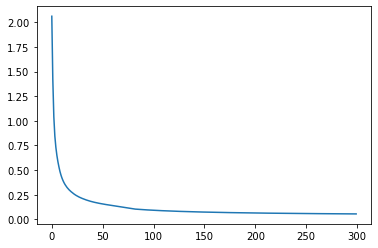

In [5]:

# temp.NPG_step(verbose = True)
np.random.seed(10)

# temp.NPG_step(verbose = True)
temp = CMDP_NPG(reward, utility, s, a, b, rho, gamma, prob_transition, model)
for i in range(300):
    temp.NPG_step(verbose = False)
plt.plot(temp.gap)

In [6]:
np.random.seed(10)

ar_temp = CMDP_ARNPG(reward, utility, s, a, b, rho, gamma, prob_transition, model)

for i in range(300):
    ar_temp.ARNPG_step(verbose = False)

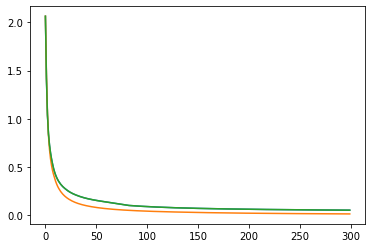

In [10]:
plt.plot(temp.gap)
plt.plot(ar_temp.gap[:])
plt.plot(gap[:])

In [8]:
def naturalgradient(prob_transition, reward, utility, theta, s, a, rho, gamma, dual, old_prob, old_vg):
    prob = theta_to_policy(theta, s, a)

    Pi = get_Pi(prob, s, a)
    mat = np.identity(s * a) - gamma * np.matmul(prob_transition, Pi)
    P_theta = np.matmul(Pi, prob_transition)
    d_pi = (1 - gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(s) - gamma * P_theta))), rho)

    Vr = np.dot(np.linalg.inv(np.identity(s) - gamma * P_theta), np.matmul(Pi, reward))
    Vg = np.dot(np.linalg.inv(np.identity(s) - gamma * P_theta), np.matmul(Pi, utility))

    vrvals = np.dot(np.transpose(Vr), rho)
    vgvals = np.dot(np.transpose(Vg), rho)
    vvals = vrvals + (dual - dualstep * (old_vg - b)) * vgvals

    d_s_pi = np.linalg.inv(np.identity(s) - gamma * P_theta)  # |S|*|S|
    kl_divergence = np.sum(prob.reshape(s, a) * np.log(prob.reshape(s, a) / old_prob.reshape(s, a)), axis=1)
    regular_term = np.dot(d_s_pi, kl_divergence)
    V = Vr + (dual - dualstep * (old_vg - b)) * Vg - alpha / (1 - gamma) * regular_term
    qvals = Q_cal(V, reward + (dual - dualstep * (old_vg - b)) * utility + alpha * np.log(old_prob))

    MPinverse = np.linalg.pinv(Fisher_info(prob, d_pi))
    gradient = grad(qvals - vvals - alpha * np.log(prob), prob, d_pi)
    return np.matmul(MPinverse, gradient)


In [9]:
# NPG with softmax parameterization
np.random.seed(10)
N = 300
theta = np.random.uniform(0, 1, size=s * a)
dual = 0
gap = []
violation = []
acc_avg_gap = 0
acc_avg_violation = 0
div_number = 1  # 000
step = 1
dualstep = 1

for k in range(N):
    prob = theta_to_policy(theta, s, a)
    Pi = get_Pi(prob, s, a)
    mat = np.identity(s * a) - gamma * np.matmul(prob_transition, Pi)

    qrvals = np.dot(np.linalg.inv(mat), reward)
    qgvals = np.dot(np.linalg.inv(mat), utility)
    qvals = qrvals + dual * qgvals

    vrvals = ell(qrvals, prob, rho)
    vgvals = ell(qgvals, prob, rho)
    vvals = vrvals + dual * vgvals

    P_theta = np.matmul(Pi, prob_transition)
    d_pi = (1 - gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(s) - gamma * P_theta))), rho)
    MPinverse = np.linalg.pinv(Fisher_info(prob, d_pi))
    gradient = grad(qvals - vvals, prob, d_pi)
    naturalgradient = np.matmul(MPinverse, gradient)

    # primal natural gradient ascent
    # dual projected sub-gradient descent
    theta += step * naturalgradient
    dual = proj(dual - dualstep * (ell(qgvals, prob, rho) - b))

    if k % div_number == 0:
        avg_reward = ell(qrvals, prob, rho)
        avg_violation = b - ell(qgvals, prob, rho)
        # acc_avg_gap = model.objective_value - avg_reward
        # acc_avg_violation = avg_violation
        # print('Average gap:', acc_avg_gap)
        # print('Average violation:', acc_avg_violation)
        # gap.append(acc_avg_gap)
        # violation.append(acc_avg_violation)
        acc_avg_gap += model.objective_value - avg_reward
        acc_avg_violation += avg_violation
        print('Average gap:', acc_avg_gap / (k + 1))
        print('Average volation:', acc_avg_violation / (k + 1))
        gap.append(acc_avg_gap / (k + 1))
        violation.append(acc_avg_violation / (k + 1))

Average gap: 2.06249164330517
Average volation: 0.5135929243923476
Average gap: 1.4191474856995483
Average volation: 0.4828600562497072
Average gap: 1.0408245140364343
Average volation: 0.27498157029046083
Average gap: 0.845039219001037
Average volation: 0.08595957331431126
Average gap: 0.7310161255061403
Average volation: -0.04183788404990292
Average gap: 0.6492246119528758
Average volation: -0.12501637128865806
Average gap: 0.5851811317378056
Average volation: -0.17799285501098083
Average gap: 0.5328708656944107
Average volation: -0.2118132174906321
Average gap: 0.48660492056877125
Average volation: -0.2289103589049336
Average gap: 0.44940818951717754
Average volation: -0.2424621306944909
Average gap: 0.4188805953839283
Average volation: -0.25350118306401126
Average gap: 0.3933789974125756
Average volation: -0.2626672034876208
Average gap: 0.3717550992409206
Average volation: -0.2703936740904772
Average gap: 0.35318391084302553
Average volation: -0.27698586446500106
Average gap: 0.33

In [109]:
np.random.seed(10)

N = 300
dualstep = 1
step = 1
alpha = 0.2
theta = np.random.uniform(0, 1, size=s * a)
dual = 0
gap = []
violation = []
acc_avg_gap = 0
acc_avg_violation = 0
div_number = 1  # 000
inner = 1

for k in range(N):
    prob = theta_to_policy(theta, s, a)
    Pi = get_Pi(prob, s, a)
    mat = np.identity(s * a) - gamma * np.matmul(prob_transition, Pi)
    P_theta = np.matmul(Pi, prob_transition)
    d_pi = (1 - gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(s) - gamma * P_theta))), rho)

    # V(s): |S|*1
    Vr = np.dot(np.linalg.inv(np.identity(s) - gamma * P_theta), np.matmul(Pi, reward))
    Vg = np.dot(np.linalg.inv(np.identity(s) - gamma * P_theta), np.matmul(Pi, utility))

    # V(\rho): 1*1
    vrvals = np.dot(np.transpose(Vr), rho)
    vgvals = np.dot(np.transpose(Vg), rho)
    vvals = vrvals + (dual - dualstep * (vgvals - b)) * vgvals

    qrvals = Q_cal(Vr, reward)
    qgvals = Q_cal(Vg, utility)
    qvals = qrvals + (dual - dualstep * (vgvals - b)) * qgvals

    if k % div_number == 0:
        avg_reward = ell(qrvals, prob, rho)
        avg_violation = b - ell(qgvals, prob, rho)
        # acc_avg_gap = model.objective_value - avg_reward
        # acc_avg_violation = avg_violation
        # print('Average gap:', acc_avg_gap)
        # print('Average violation:', acc_avg_violation)
        # gap.append(acc_avg_gap)
        # violation.append(acc_avg_violation)
        acc_avg_gap += model.objective_value - avg_reward
        acc_avg_violation += avg_violation
        print('Average gap:', acc_avg_gap / (k + 1))
        print('Average violation:', acc_avg_violation / (k + 1))
        gap.append(acc_avg_gap / (k + 1))
        violation.append(acc_avg_violation / (k + 1))

    old_prob = prob
    for l in range(inner):
        ng = naturalgradient(prob_transition, reward, utility, theta, s, a, rho, gamma, dual, old_prob, vgvals)
        theta += step * ng

    prob = theta_to_policy(theta, s, a)
    Pi = get_Pi(prob, s, a)
    mat = np.identity(s * a) - gamma * np.matmul(prob_transition, Pi)
    P_theta = np.matmul(Pi, prob_transition)
    d_pi = (1 - gamma) * np.dot(np.transpose((np.linalg.inv(np.identity(s) - gamma * P_theta))), rho)

    Vg = np.dot(np.linalg.inv(np.identity(s) - gamma * P_theta), np.matmul(Pi, utility))
    qgvals = Q_cal(Vg, utility)
    dual = max(dual - dualstep * (ell(qgvals, prob, rho) - b), dualstep * (ell(qgvals, prob, rho) - b))


Average gap: 2.06249164330517
Average violation: 0.5135929243923485
Average gap: 1.4549687861083758
Average violation: 0.09901370346007998
Average gap: 1.0619953749319937
Average violation: 0.03021339227059568
Average gap: 0.8277766840542959
Average violation: -0.01519188147702022
Average gap: 0.684370734559416
Average violation: -0.04198731624966969
Average gap: 0.5875471508922862
Average violation: -0.05901197693143664
Average gap: 0.5176945582750613
Average violation: -0.07033695330530795
Average gap: 0.46474663811365724
Average violation: -0.07759820773167408
Average gap: 0.42280810850583844
Average violation: -0.08076813073550834
Average gap: 0.3870479498326226
Average violation: -0.07486051018862754
Average gap: 0.3536559687467146
Average violation: -0.059718776981882264
Average gap: 0.32573670585641556
Average violation: -0.05350643023278915
Average gap: 0.3017767777308692
Average violation: -0.04803870052177009
Average gap: 0.28108709751237054
Average violation: -0.043674544106

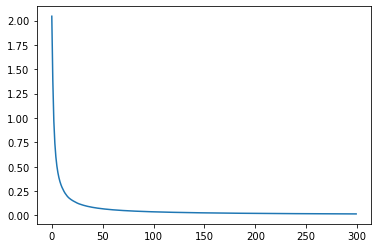

In [100]:
import matplotlib.pyplot as plt
plt.plot(gap)

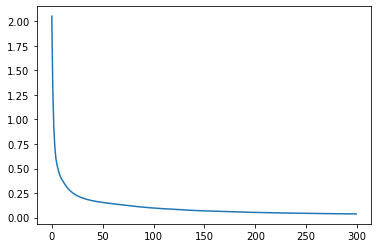

In [ ]:
# Saving the data. This can be loaded to make the figure again.
np.savetxt('NPG-PD_gap_s20a10g8b3.txt', gap)
np.savetxt('NPG-PD_violation_s20a10g8b3.txt', violation)